In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt
from pandas import DataFrame, melt
#가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

#분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

#사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests



In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('tips')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/tips.xlsx
[desc] 식당 고객의 결제 금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등 기본 정보를 담은 데이터 분석·시각화 실습용 샘플 데이터 (출처: https://www.kaggle.com/datasets/sakshisatre/tips-dataset)

field       description
----------  -------------
total_bill  총 결제 금액
tip         팁 금액
sex         성별
smoker      흡연 여부
day         방문 요일
time        방문 시간대
size        일행 규모


===== 데이터 크기 확인 =====
데이터셋 크기 : (244, 7)
열 개수: 7
행 개수: 244

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df = origin[(origin['day'] == 'Fri') | (origin['day'] == 'Sat') | (origin['day'] == 'Sun')]
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


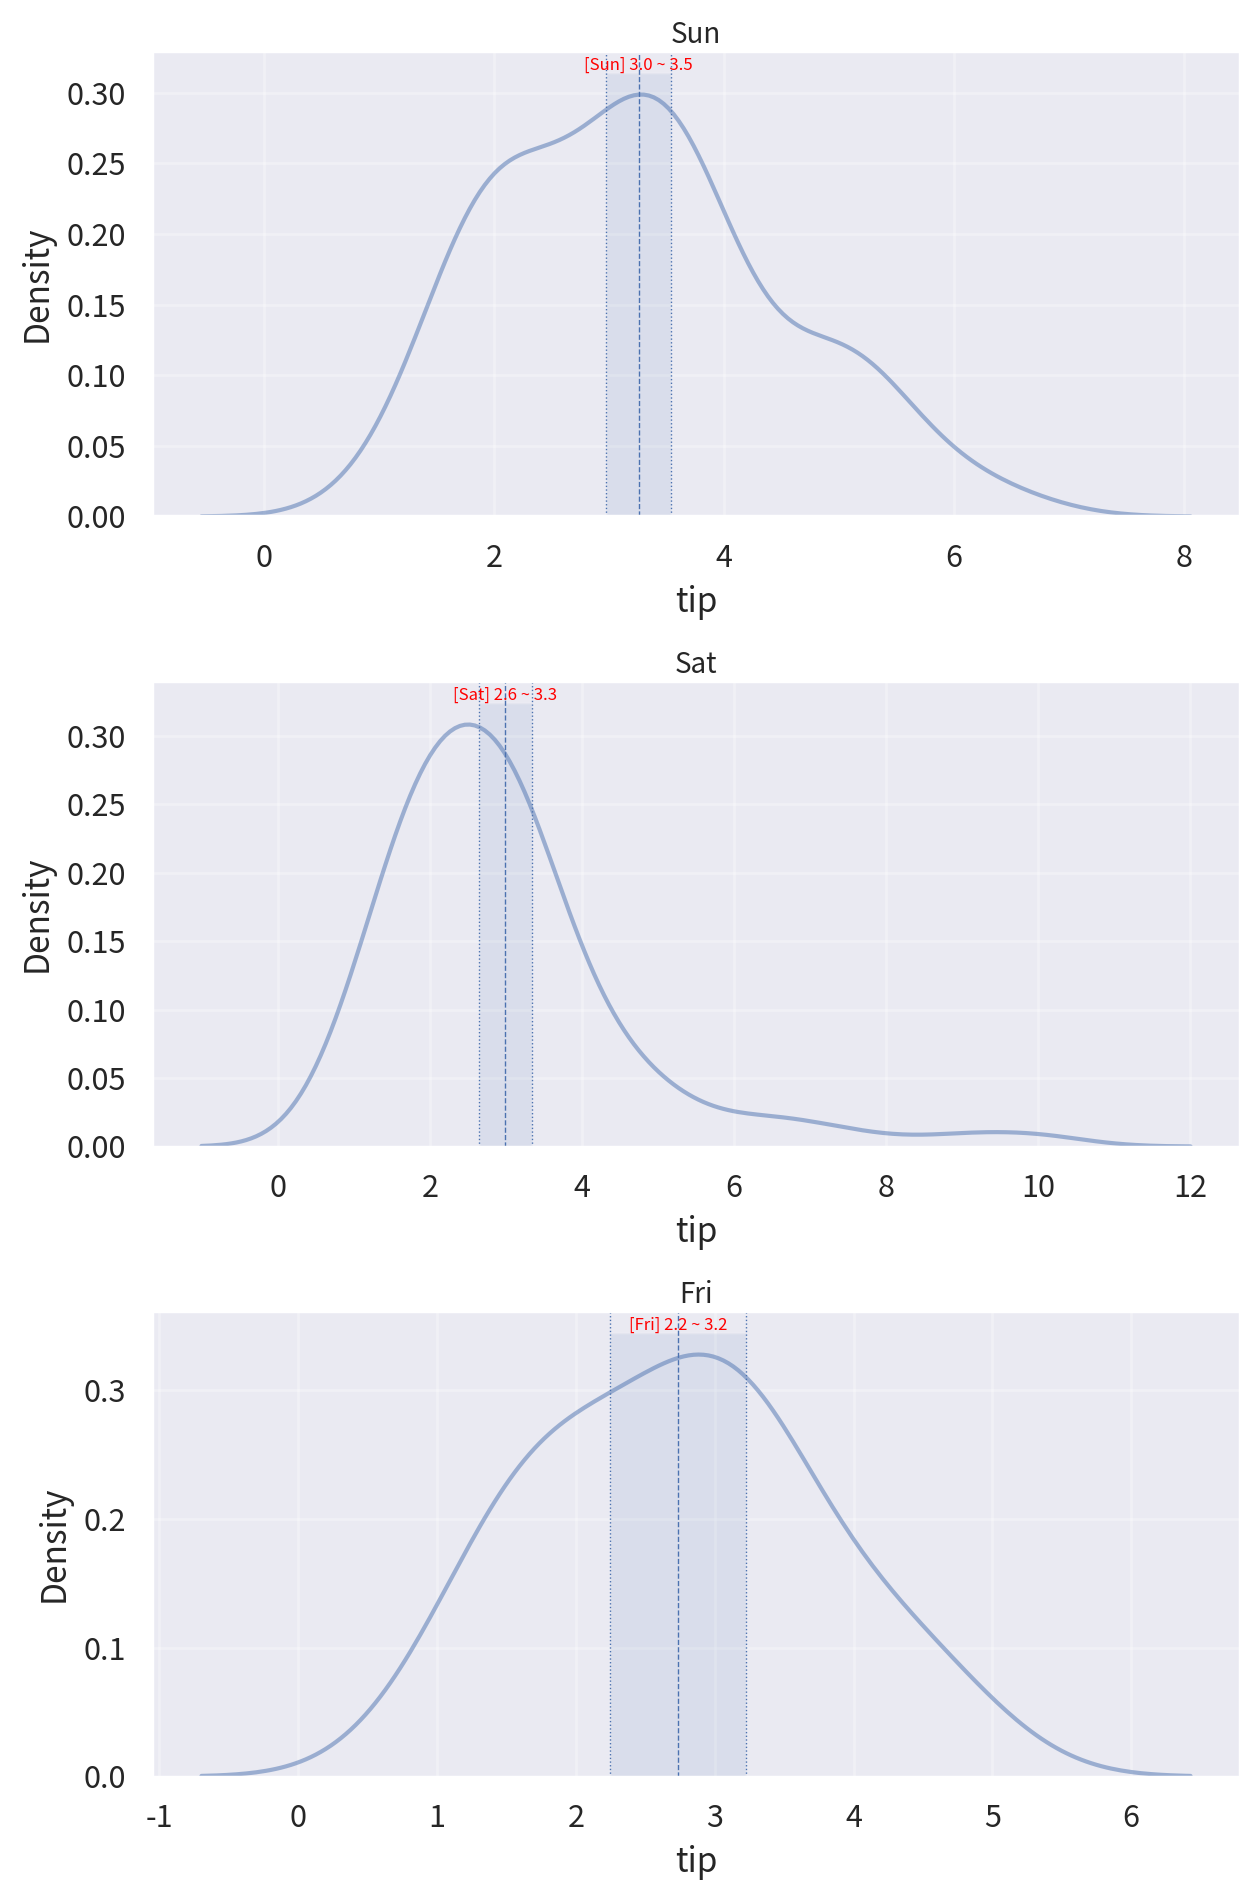

In [5]:
field = 'tip'

hue_field = 'day'

hue_values = df[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 640 * 3             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(hue_values):
    temp = df[df[hue_field]==v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize = 10, pad=3)

    # 신뢰구간
    max = temp[field].max()                         #최대값
    clevel = 0.95                               #신뢰수준
    dof = len(temp[field]) - 1                       #자유도
    sp_mean = temp[field].mean()                    #표본평균
    sp_std = temp[field].std(ddof = 1)           #표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) #표본표준오차
    cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    #평균 표시
    ymin,ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

    #텍스트 그리기
    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
            horizontalalignment='center',
            verticalalignment='bottom', 
            fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

In [6]:
groups = [(name, grp['tip']) for name, grp in df.groupby('day')]

test_name = ""
report = []
normal_dist = True

for name, series in groups:
    s, p = normaltest(series)
    normalize= p>0.05
    report.append({
        "field":name,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
    n = "Bartlett"
    #정규성을 충족할 경우의 검정 방법
    s,p = bartlett(*[s.values for _, s in groups]) #모든 컬럼의 데이터를 한번에 전달
else:
    n = "Levene"
    #정규성을 충족하지 못할 경우의 검정 방법
    s,p = levene(*[s.values for _, s in groups], center='median') #모든 컬럼의 데이터를 한번에 전달

equal_var = p>0.05
report.append({
    "field": test_name,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
Fri,0.416676,8.119325e-01,True
Sat,49.144308,2.130341e-11,False
Sun,3.396232,1.830280e-01,True
,0.651391,5.225516e-01,True


In [7]:
anova_df = origin[['tip','day']].copy()
anova_df

,tip,day
0,1.01,Sun
1,1.66,Sun
2,3.50,Sun
3,3.31,Sun
4,3.61,Sun
...,...,...
239,5.92,Sat
240,2.00,Sat
241,2.00,Sat
242,1.75,Sat


In [8]:
if equal_var:
    pg_anova = anova(anova_df, dv='tip', between='day')
else:
    pg_anova = welch_anova(anova_df, dv='tip', between='day')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,day,3,240,1.672355,0.173589,0.020476


In [9]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")



'statistic: 1.672, p-value: 0.174, 귀무가설 채택'

In [10]:
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='tip', between='day')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=anova_df, dv='tip', between='day')

hoc_df

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Fri,Sat,2.734737,2.993103,-0.258367,0.348935,-0.740444,0.880645,-0.166274
1,Fri,Sun,2.734737,3.255132,-0.520395,0.353432,-1.472405,0.455805,-0.431509
2,Fri,Thur,2.734737,2.771452,-0.036715,0.361324,-0.101612,0.999623,-0.030468
3,Sat,Sun,2.993103,3.255132,-0.262028,0.216349,-1.211136,0.620382,-0.178644
4,Sat,Thur,2.993103,2.771452,0.221652,0.229016,0.967846,0.767858,0.148857
5,Sun,Thur,3.255132,2.771452,0.483680,0.235811,2.051132,0.172421,0.388762


연습문제 1
- tree_weight 데이터셋은 소나무 품종별 무게를 조사한 데이터이다.
- 소나무 품종별로 평균 무게에 차이가 있는지 분석하라

In [11]:
origin = load_data('tree_weight')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/tree_weight.xlsx
[desc] 소나무 품종별 무게를 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (30, 2)
열 개수: 2
행 개수: 30

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  30 non-null     float64
 1   group   30 non-null     object 
dtypes: float64(1), object(1)
memory usage: 612.0+ bytes
None


,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


In [12]:
df = origin.copy()
df.head()

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


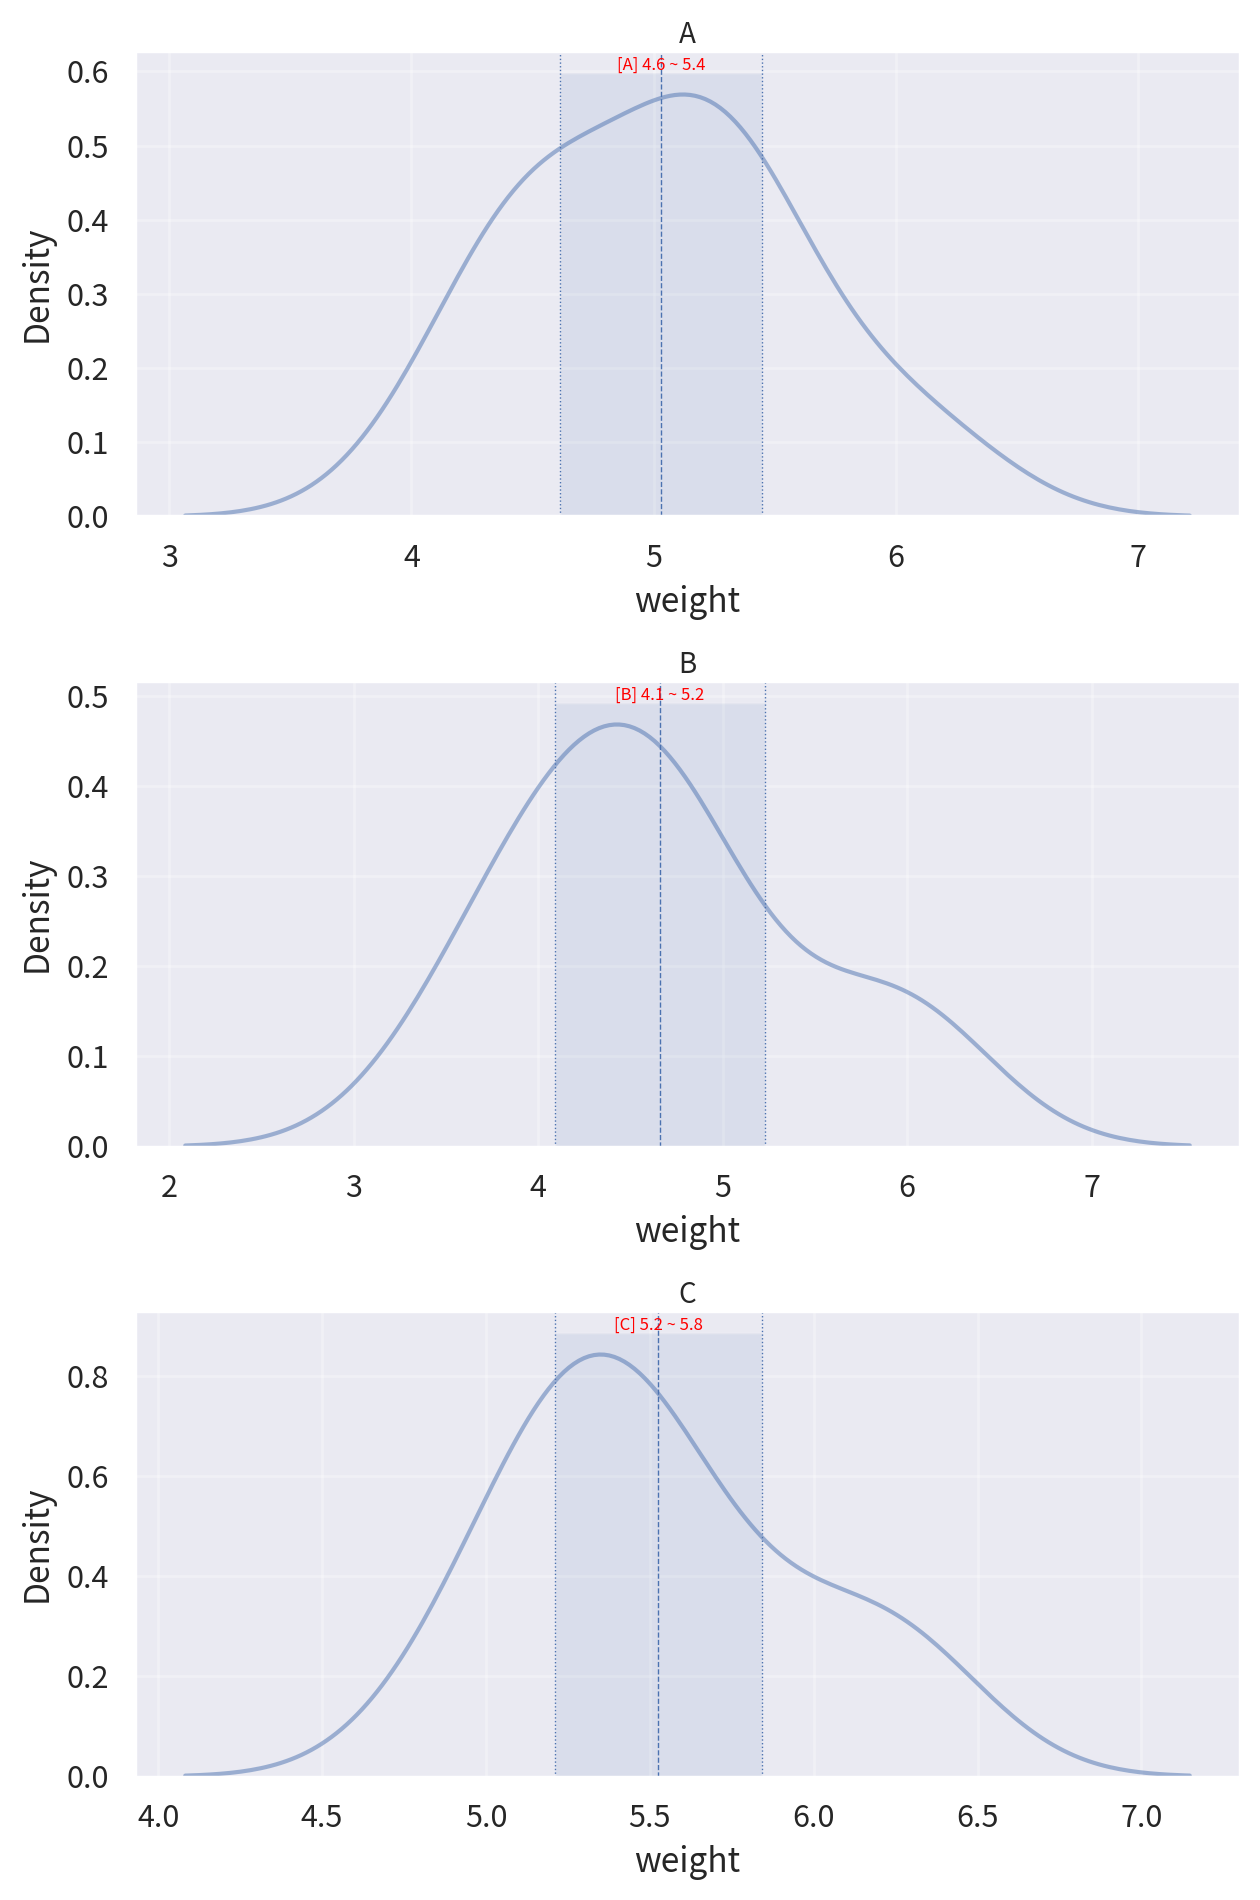

In [13]:
field = 'weight'

hue_field = 'group'

hue_values = df[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 640 * hue_count             #그래프 세로 크기
rows = hue_count                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(hue_values):
    temp = df[df[hue_field]==v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize = 10, pad=3)

    # 신뢰구간
    max = temp[field].max()                         #최대값
    clevel = 0.95                               #신뢰수준
    dof = len(temp[field]) - 1                       #자유도
    sp_mean = temp[field].mean()                    #표본평균
    sp_std = temp[field].std(ddof = 1)           #표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) #표본표준오차
    cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    #평균 표시
    ymin,ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

    #텍스트 그리기
    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
            horizontalalignment='center',
            verticalalignment='bottom', 
            fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

In [14]:
groups = [(name, grp['weight']) for name, grp in df.groupby('group')]

test_name = ""
report = []
normal_dist = True

for name, series in groups:
    s, p = normaltest(series)
    normalize= p>0.05
    report.append({
        "field":name,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
    n = "Bartlett"
    #정규성을 충족할 경우의 검정 방법
    s,p = bartlett(*[s.values for _, s in groups]) #모든 컬럼의 데이터를 한번에 전달
else:
    n = "Levene"
    #정규성을 충족하지 못할 경우의 검정 방법
    s,p = levene(*[s.values for _, s in groups], center='median') #모든 컬럼의 데이터를 한번에 전달

equal_var = p>0.05
report.append({
    "field": test_name,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
A,0.233496,0.889810,True
B,0.967741,0.616393,True
C,1.013177,0.602548,True
,2.878574,0.237097,True


A,B,C 모두 P>0.05 이므로 귀무가설 채택 -> 분산이 같으니 일반 anova를 돌릴 수 있음.

ANOVA 분석 - 결과 확인 - 집단 간에 몸무게 차이가 있나?
- 귀무가설 : 모든 집단의 평균은 차이가 없다.
- 대립가설 : 적어도 한 집단의 평균은 차이가 있다.

In [15]:
if equal_var:
    pg_anova = anova(df, dv='weight', between='group')
else:
    pg_anova = welch_anova(df, dv='weight', between='group')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,4.846088,0.01591,0.264148


In [16]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")



'statistic: 4.846, p-value: 0.016, 대립가설 채택'

p-unc가 0.05보다 작으므로 적어도 한 집단의 평균은 차이가 있다.

- 에서 끝나는게 아니라 집단간 차이가 어느정도인지까지 밝혀내야함.

문제 2
- reading 데이터셋은 유아들을 대상으로 세 가지 읽는 방법을 비교, 실험하여 얻은 독서평가 점수 데이터이다.
- 세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

In [17]:
origin = load_data('reading')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/reading.xlsx
[desc] 유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 얻은 독서평가 점수 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (90, 2)
열 개수: 2
행 개수: 90

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   독서방법    90 non-null     object 
 1   점수      90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB
None


,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3


In [18]:
df = origin.copy()
df.head()

,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3


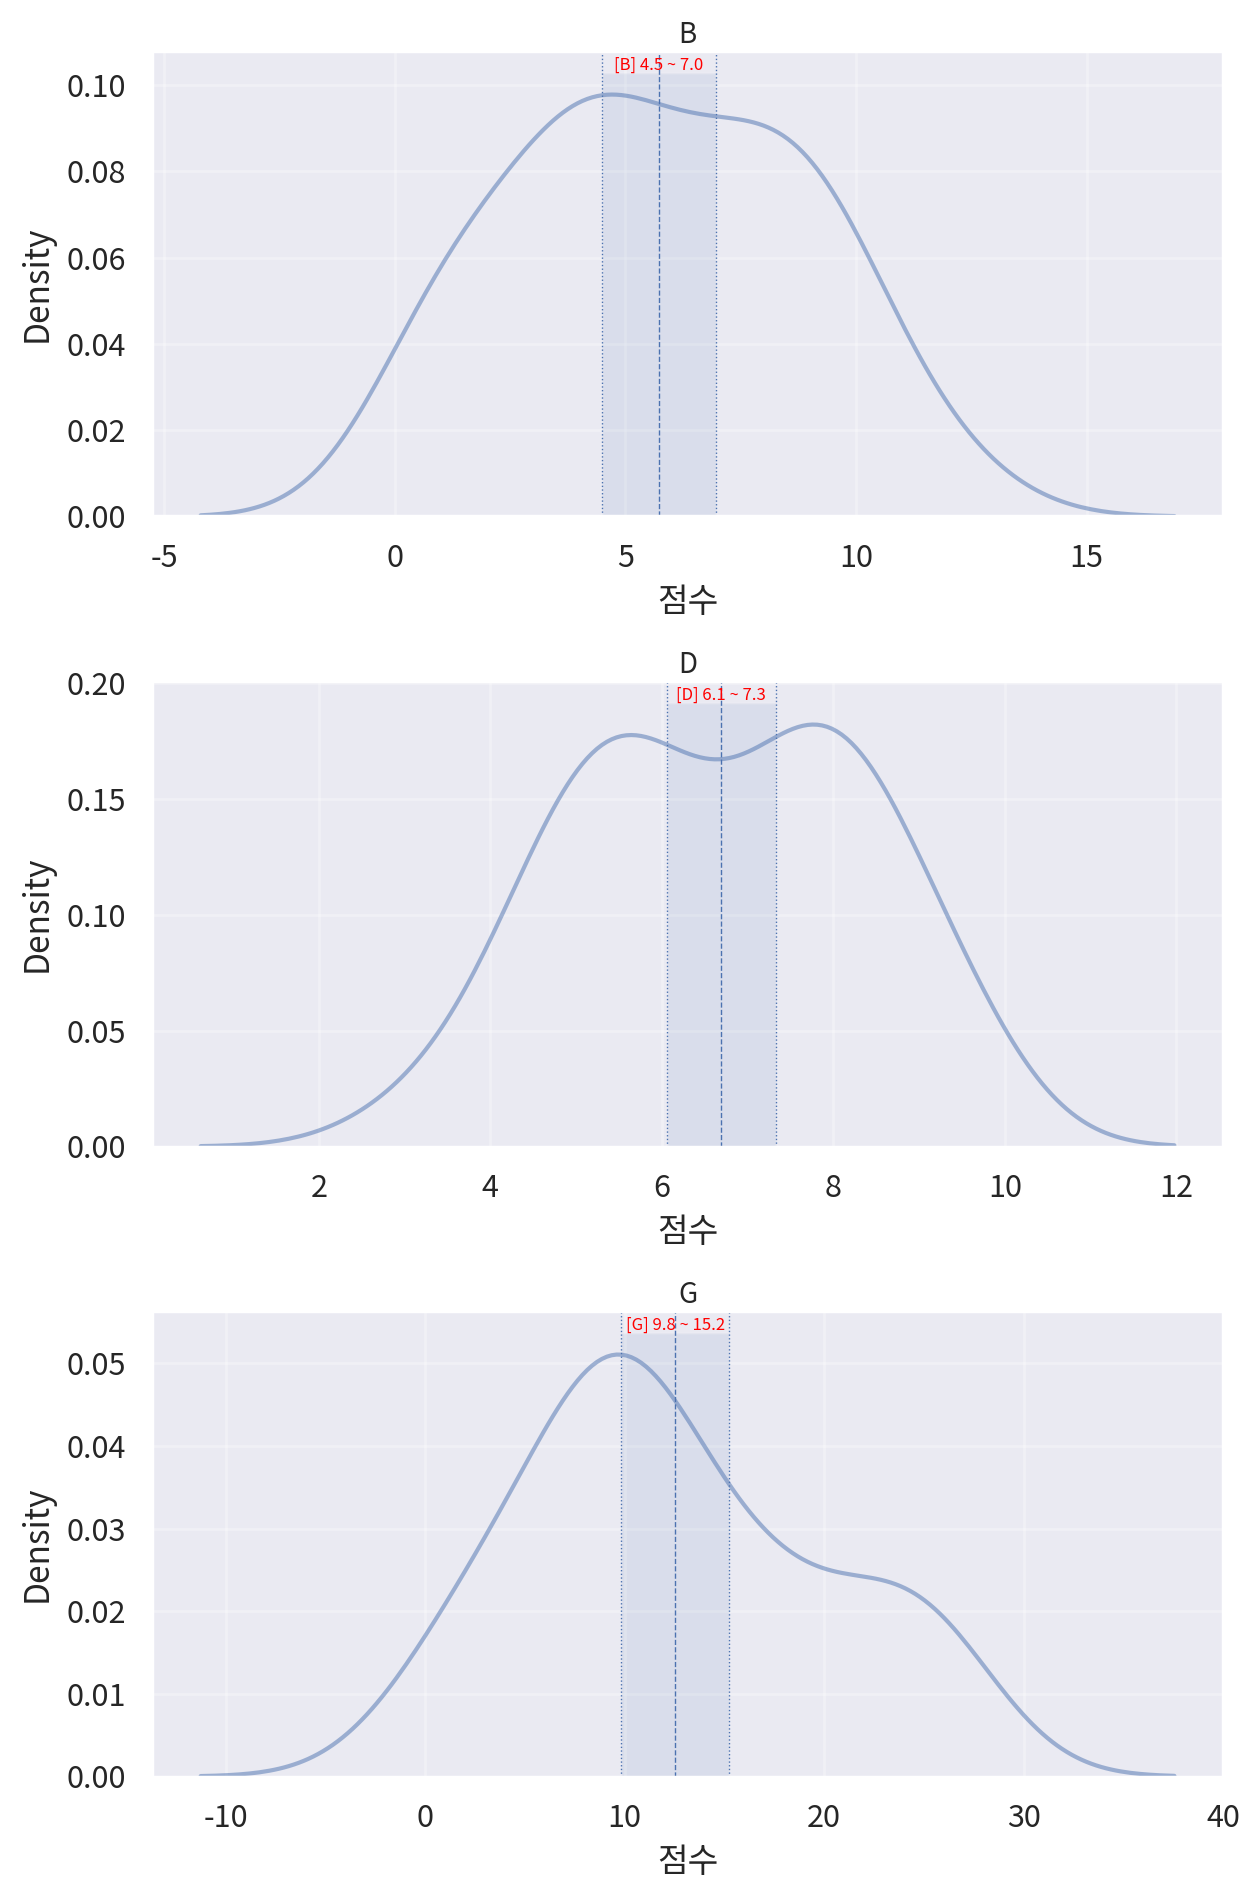

In [19]:
field = '점수'

hue_field = '독서방법'

hue_values = df[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 640 * hue_count             #그래프 세로 크기
rows = hue_count                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(hue_values):
    temp = df[df[hue_field]==v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize = 10, pad=3)

    # 신뢰구간
    max = temp[field].max()                         #최대값
    clevel = 0.95                               #신뢰수준
    dof = len(temp[field]) - 1                       #자유도
    sp_mean = temp[field].mean()                    #표본평균
    sp_std = temp[field].std(ddof = 1)           #표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) #표본표준오차
    cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    #평균 표시
    ymin,ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

    #텍스트 그리기
    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
            horizontalalignment='center',
            verticalalignment='bottom', 
            fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

In [20]:
groups = [(name, grp['점수']) for name, grp in df.groupby('독서방법')]

test_name = ""
report = []
normal_dist = True

for name, series in groups:
    s, p = normaltest(series)
    normalize= p>0.05
    report.append({
        "field":name,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
    n = "Bartlett"
    #정규성을 충족할 경우의 검정 방법
    s,p = bartlett(*[s.values for _, s in groups]) #모든 컬럼의 데이터를 한번에 전달
else:
    n = "Levene"
    #정규성을 충족하지 못할 경우의 검정 방법
    s,p = levene(*[s.values for _, s in groups], center='median') #모든 컬럼의 데이터를 한번에 전달

equal_var = p>0.05
report.append({
    "field": test_name,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
B,2.210100,3.311943e-01,True
D,2.396634,3.017015e-01,True
G,2.216900,3.300701e-01,True
,58.099241,2.420528e-13,False


p-value가 0.05보다 크니까 일반 anova ㄱㄱㄱㄱ

In [21]:
if equal_var:
    pg_anova = anova(df, dv='점수', between='독서방법')
else:
    pg_anova = welch_anova(df, dv='점수', between='독서방법')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,독서방법,2,48.204128,10.787455,0.000134,0.283461


In [22]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")



'statistic: 10.787, p-value: 0.000, 대립가설 채택'

p-unc가 0.05보다 작으므로 대립가설 채택
- 독서방법에 따른 점수차이가 존재함.(있다.)

문제 3.
- commercial 데이터셋 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료이다.
- 서울시에서 정의하는 상권의 종류는 발달상권, 골목상권, 관광특구, 전통시장이 있다.
- 상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.
- 주어진 데이터는 서울시에서 제공하는 집계가 완료된 데이터이므로 모든 결측치는 없는 상태이며 이상치도 실제 매출액 데이터이므로 별도의 정제 과정 없이 진행하는 것으로 한다.

In [23]:
origin = load_data('commercial')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/commercial.xlsx
[desc] 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료 (출처: 서울 열린데이터 광장)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (6222, 6)
열 개수: 6
행 개수: 6222

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222 entries, 0 to 6221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   quarter          6222 non-null   int64 
 1   code             6222 non-null   int64 
 2   type             6222 non-null   object
 3   name             6222 non-null   object
 4   sales_amount     6222 non-null   int64 
 5   number_of_sales  6222 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 291.8+ KB
None


,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


In [30]:
df = origin[['type','sales_amount']]
df.head()

,type,sales_amount
0,관광특구,72523644100
1,관광특구,283332346393
2,관광특구,81696730221
3,관광특구,212062656625
4,관광특구,231338386876


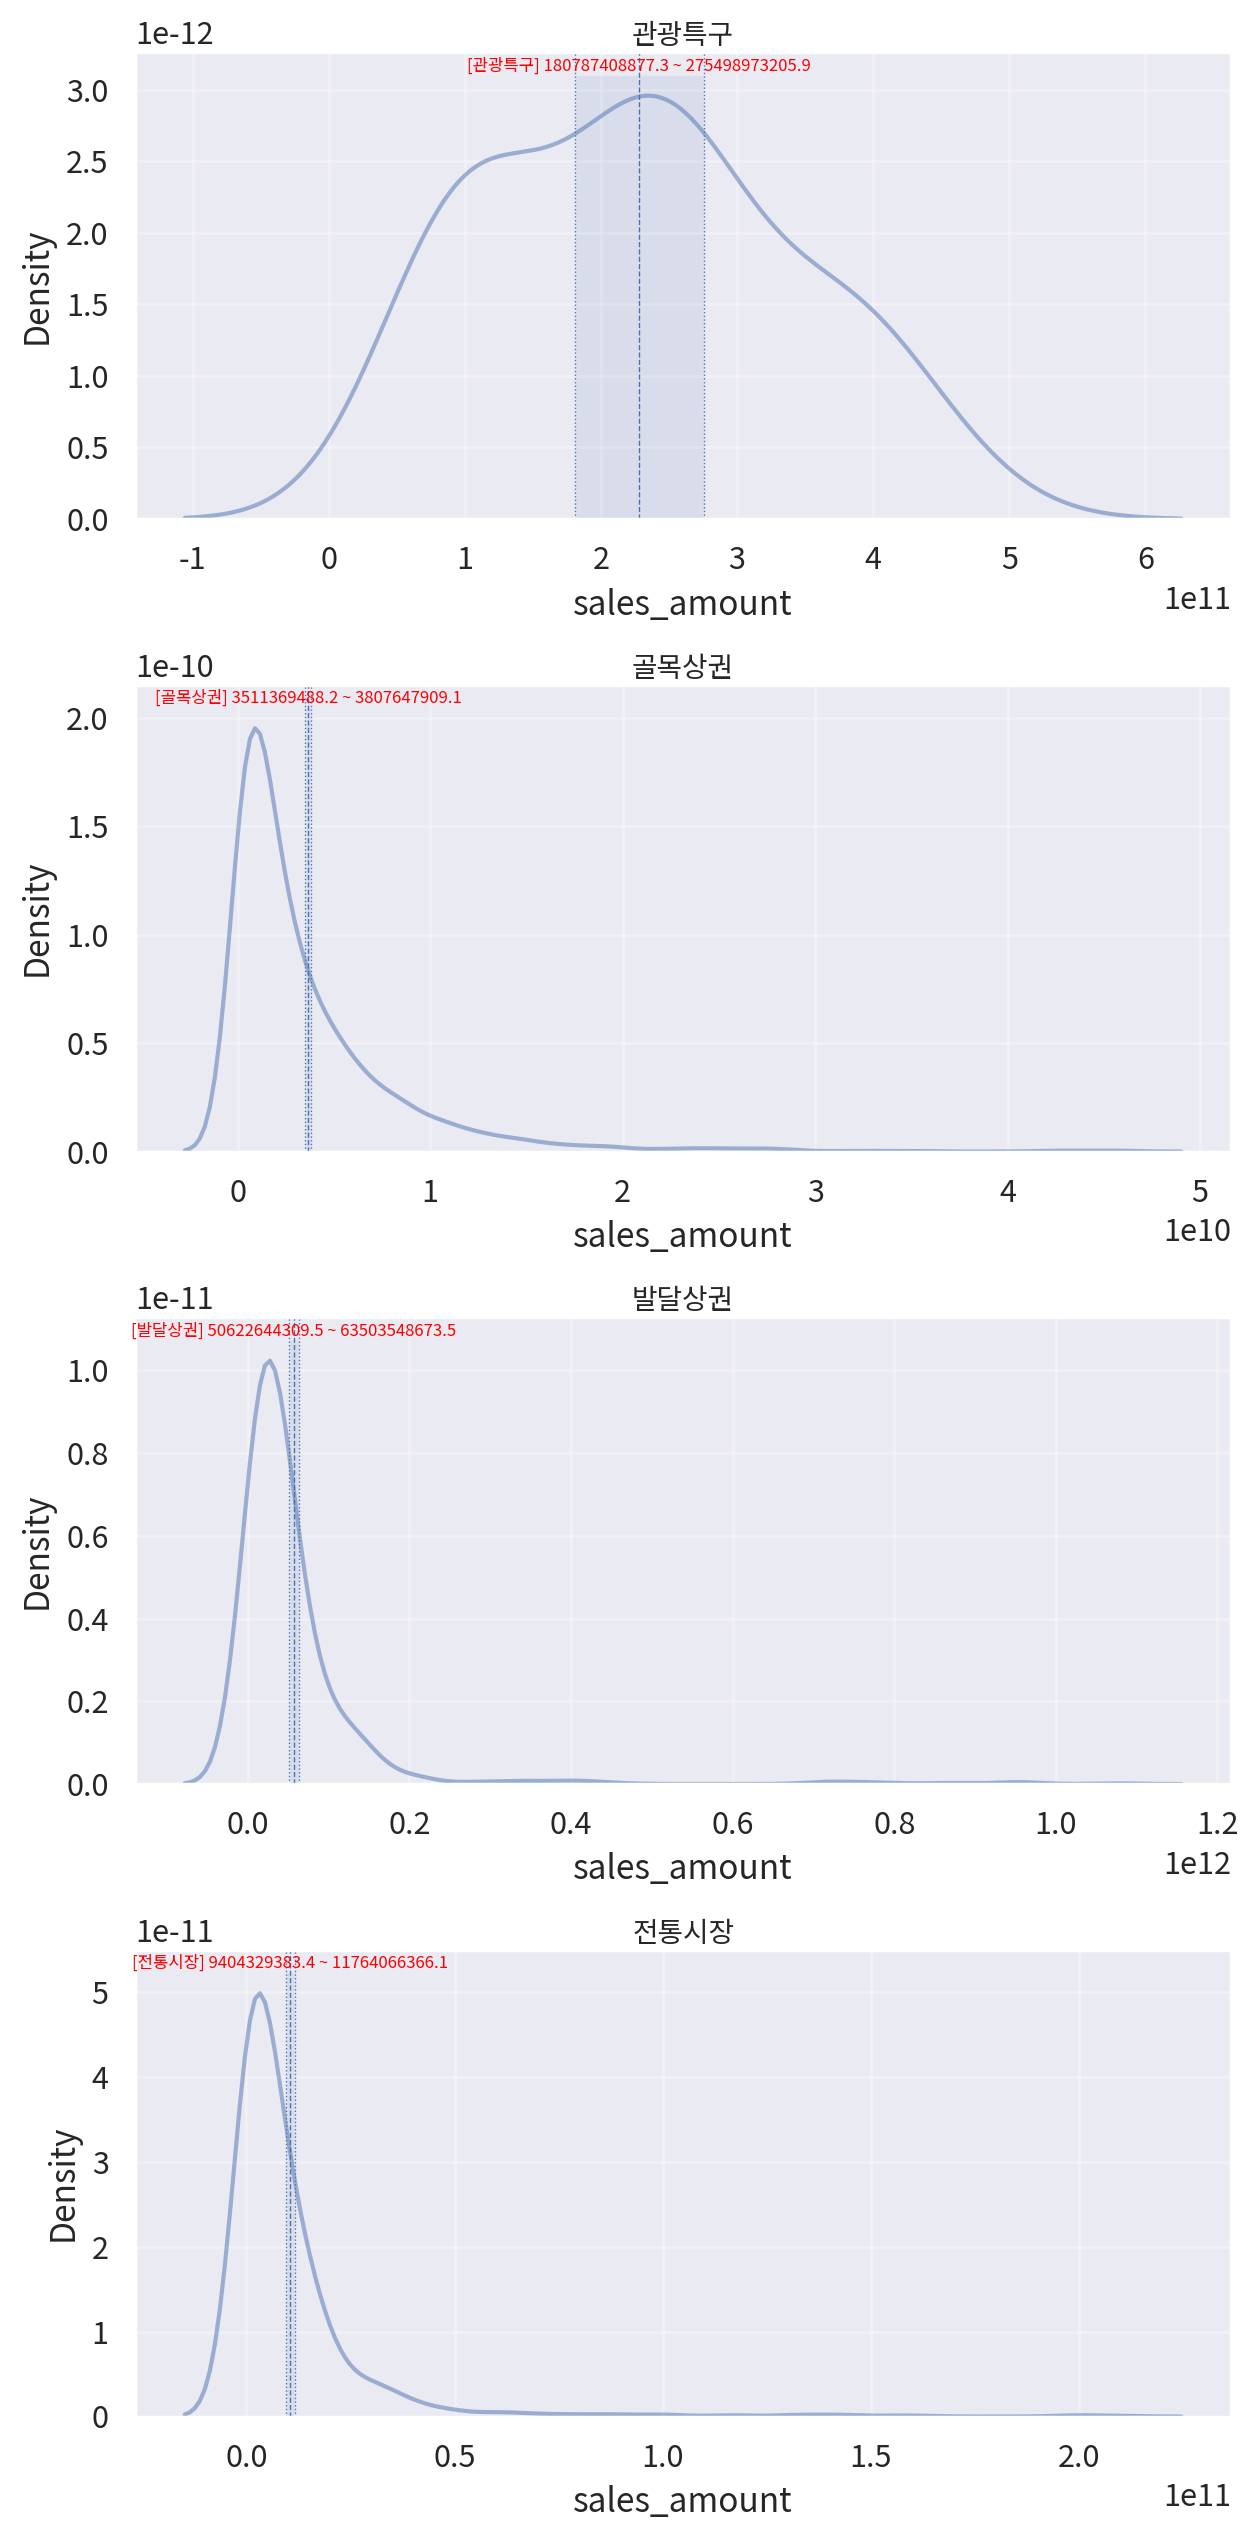

In [31]:
field = 'sales_amount'

hue_field = 'type'

hue_values = df[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 640 * hue_count             #그래프 세로 크기
rows = hue_count                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(hue_values):
    temp = df[df[hue_field]==v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize = 10, pad=3)

    # 신뢰구간
    max = temp[field].max()                         #최대값
    clevel = 0.95                               #신뢰수준
    dof = len(temp[field]) - 1                       #자유도
    sp_mean = temp[field].mean()                    #표본평균
    sp_std = temp[field].std(ddof = 1)           #표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) #표본표준오차
    cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    #평균 표시
    ymin,ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

    #텍스트 그리기
    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
            horizontalalignment='center',
            verticalalignment='bottom', 
            fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

In [32]:
groups = [(name, grp['sales_amount']) for name, grp in df.groupby('type')]

test_name = ""
report = []
normal_dist = True

for name, series in groups:
    s, p = normaltest(series)
    normalize= p>0.05
    report.append({
        "field":name,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 등분산성 검정 선택
if normal_dist:
    n = "Bartlett"
    #정규성을 충족할 경우의 검정 방법
    s,p = bartlett(*[s.values for _, s in groups]) #모든 컬럼의 데이터를 한번에 전달
else:
    n = "Levene"
    #정규성을 충족하지 못할 경우의 검정 방법
    s,p = levene(*[s.values for _, s in groups], center='median') #모든 컬럼의 데이터를 한번에 전달

equal_var = p>0.05
report.append({
    "field": test_name,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
골목상권,2949.769498,0.000000e+00,False
관광특구,2.023450,3.635912e-01,True
발달상권,1174.363632,9.776365e-256,False
전통시장,1194.779826,3.604601e-260,False
,268.725277,5.300718e-164,False


False가 다수..니까 일반 anova는 안될듯..?

In [35]:
if equal_var:
    print("=== ANOVA ===")
    pg_anova = anova(df, dv='sales_amount', between='type')
else:
    print("=== Welch ANOVA ===")
    pg_anova = welch_anova(df, dv='sales_amount', between='type')
pg_anova

=== Welch ANOVA ===


,Source,ddof1,ddof2,F,p-unc,np2
0,type,3,110.238825,161.432719,3.495920e-40,0.228001


p-unc가 0.05보다 작으므로 대립가설 채택
- 평균 매출액은 상권 종류에 따라 차이가 있다.

In [34]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 161.433, p-value: 0.000, 대립가설 채택'

모든 문제의 결과는 사후검정 결과 요약이 필수 
- 효과 크기는 절댓값 크기로 비교할 것.

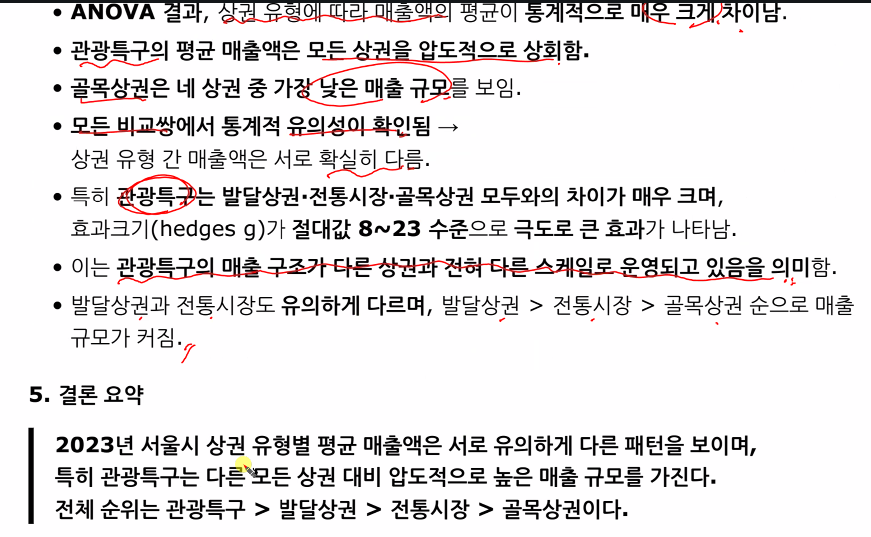